In [25]:
# ─── Imports ───────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ─── Load Data ─────────────────────────────────────────────────────────────
df = pd.read_excel("ALL_BN.xlsx")
print("✅ Data Loaded Successfully!")
print(f"Original Shape: {df.shape}")

# ─── Drop Nulls in Features and Target ─────────────────────────────────────
required_columns = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'Ozone', 'AQI']
missing_before = df[required_columns].isna().sum().sum()
df = df.dropna(subset=required_columns)
missing_after = df[required_columns].isna().sum().sum()
print(f"🧹 Dropped {missing_before - missing_after} rows with missing values.")

# ─── Remove Outliers in AQI ────────────────────────────────────────────────
Q1, Q3 = df['AQI'].quantile([0.25, 0.75])
IQR = Q3 - Q1
outlier_mask = (df['AQI'] < Q1 - 1.5*IQR) | (df['AQI'] > Q3 + 1.5*IQR)
outliers_removed = outlier_mask.sum()
df = df[~outlier_mask]
print(f"🚫 Removed {outliers_removed} outliers in AQI using IQR method.")

print(f"📊 Final Dataset Shape: {df.shape}")
print("\n🔍 Features Sent to Model:", required_columns[:-1])
print("🎯 Target Sent to Model: AQI")

print("\n📄 Head of Final Dataset:")
print(df.head())

print("\n📄 Tail of Final Dataset:")
print(df.tail())

# ─── Dataset Splits ────────────────────────────────────────────────────────
df_train = df[df['Timestamp'].dt.year <= 2023]
features = required_columns[:-1]
target = 'AQI'
X = df_train[features].copy()
y = df_train[target].copy()

# Chronological Train-Test Split
split_index = int(0.8 * len(df_train))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# ─── Feature Scaling ───────────────────────────────────────────────────────
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ─── Taylor Diagram Metrics Function ───────────────────────────────────────
def print_taylor_metrics(y_true, y_pred, model_name):
    std_ref = np.std(y_true, ddof=0)
    std_model = np.std(y_pred, ddof=0)
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    centered_rmse = np.sqrt(np.mean(((y_pred - np.mean(y_pred)) - (y_true - np.mean(y_true)))**2))
    print(f"\n📊 Taylor Diagram Metrics for {model_name}:")
    print(f"    Std_Ref        : {std_ref:.4f}")
    print(f"    Std_Model      : {std_model:.4f}")
    print(f"    Correlation    : {corr:.4f}")
    print(f"    Centered RMSE  : {centered_rmse:.4f}")

# ─── Random Forest Hyperparameter Tuning ───────────────────────────────────
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(rf, rf_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)
rf_best = rf_grid.best_estimator_
rf_pred = rf_best.predict(X_test_scaled)

# Random Forest Evaluation
rf_mse = mean_squared_error(y_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_pred)
print("\n🌲 Random Forest Regressor:")
print(f"    Best Params : {rf_grid.best_params_}")
print(f"    MSE         : {rf_mse:.2f}")
print(f"    RMSE        : {rf_rmse:.2f}")
print(f"    R² Score    : {rf_r2:.4f}")
print_taylor_metrics(y_test, rf_pred, "Random Forest")

# ─── Decision Tree Hyperparameter Tuning ───────────────────────────────────
dt_param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
dt = DecisionTreeRegressor(random_state=42)
dt_grid = GridSearchCV(dt, dt_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
dt_grid.fit(X_train_scaled, y_train)
dt_best = dt_grid.best_estimator_
dt_pred = dt_best.predict(X_test_scaled)

# Decision Tree Evaluation
dt_mse = mean_squared_error(y_test, dt_pred)
dt_rmse = np.sqrt(dt_mse)
dt_r2 = r2_score(y_test, dt_pred)
print("\n🌳 Decision Tree Regressor:")
print(f"    Best Params : {dt_grid.best_params_}")
print(f"    MSE         : {dt_mse:.2f}")
print(f"    RMSE        : {dt_rmse:.2f}")
print(f"    R² Score    : {dt_r2:.4f}")
print_taylor_metrics(y_test, dt_pred, "Decision Tree")



✅ Data Loaded Successfully!
Original Shape: (2347, 20)
🧹 Dropped 2 rows with missing values.
🚫 Removed 14 outliers in AQI using IQR method.
📊 Final Dataset Shape: (2331, 20)

🔍 Features Sent to Model: ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'Ozone']
🎯 Target Sent to Model: AQI

📄 Head of Final Dataset:
                        Station  PostelCode  Timestamp  PM2.5    PM10    NO2  \
0  Bapuji Nager,Bengaluru-KSPCB      560026 2019-01-01  66.20  121.35  80.22   
1  Bapuji Nager,Bengaluru-KSPCB      560026 2019-01-02  52.06  100.73  77.26   
2  Bapuji Nager,Bengaluru-KSPCB      560026 2019-01-03  54.24  109.91  79.76   
3  Bapuji Nager,Bengaluru-KSPCB      560026 2019-01-04  56.64  113.99  82.45   
4  Bapuji Nager,Bengaluru-KSPCB      560026 2019-01-05  50.48  101.07  82.87   

     NH3   SO2    CO  Ozone   PM2.5 AQI    PM10 AQI  NO2 AQI  NH3 AQI  \
0  13.74  8.50  1.38  86.96  120.666667  114.233333  100.220   3.4350   
1  13.56  8.00  1.11  77.22   86.766667  100.486667   96.575   3

✅ Data Loaded Successfully!
Original Shape: (2347, 20)
🧹 Dropped 2 rows with missing values.
🚫 Removed 14 outliers in AQI using IQR method.
📊 Final Dataset Shape: (2331, 20)

🔍 Features Sent to Model: ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'Ozone']
🎯 Target Sent to Model: AQI

🌲 Random Forest Regressor:
    Best Params : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
    MSE         : 34.86
    RMSE        : 5.90
    R² Score    : 0.9706

📊 Taylor Diagram Metrics for Random Forest:
    Std_Ref        : 34.4138
    Std_Model      : 33.6119
    Correlation    : 0.9852
    Centered RMSE  : 5.9012

🌳 Decision Tree Regressor:
    Best Params : {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
    MSE         : 43.65
    RMSE        : 6.61
    R² Score    : 0.9631

📊 Taylor Diagram Metrics for Decision Tree:
    Std_Ref        : 34.4138
    Std_Model      : 34.0119
    Correlation    : 0.9818
    Centered RMSE  : 6.5394


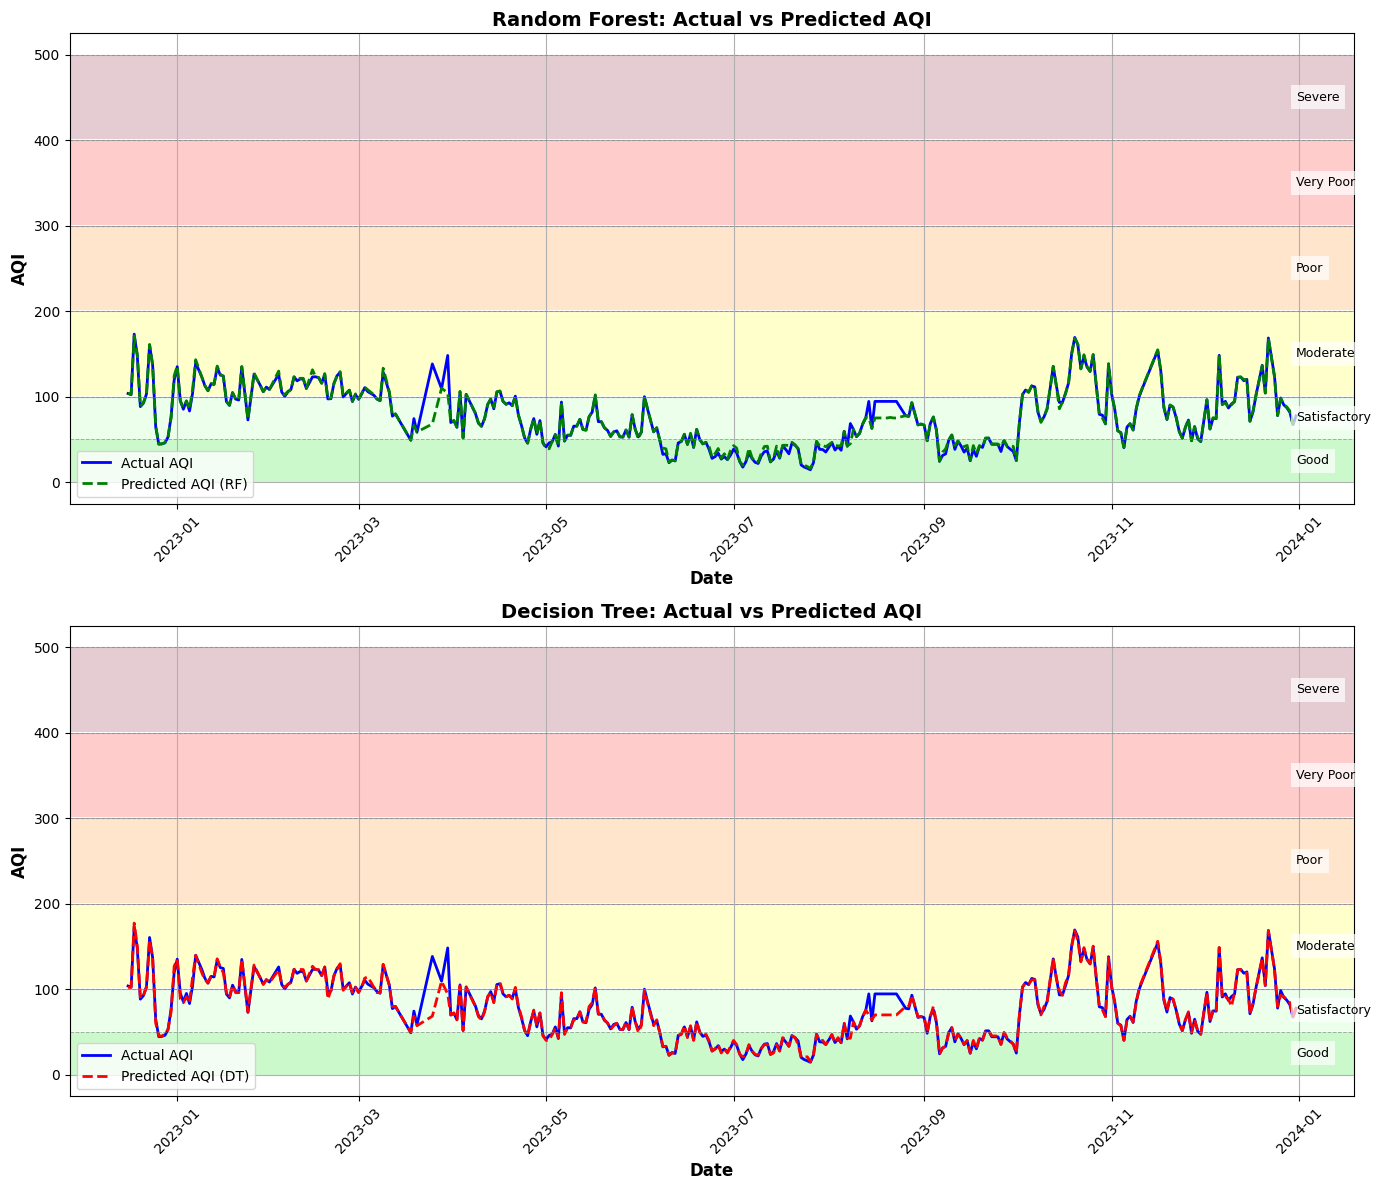

In [28]:
# ─── Imports ───────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ─── Load Data ─────────────────────────────────────────────────────────────
df = pd.read_excel("ALL_BN.xlsx")
print("✅ Data Loaded Successfully!")
print(f"Original Shape: {df.shape}")

# ─── Drop Nulls in Features and Target ─────────────────────────────────────
required_columns = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'Ozone', 'AQI']
missing_before = df[required_columns].isna().sum().sum()
df = df.dropna(subset=required_columns)
missing_after = df[required_columns].isna().sum().sum()
print(f"🧹 Dropped {missing_before - missing_after} rows with missing values.")

# ─── Remove Outliers in AQI ────────────────────────────────────────────────
Q1, Q3 = df['AQI'].quantile([0.25, 0.75])
IQR = Q3 - Q1
outlier_mask = (df['AQI'] < Q1 - 1.5*IQR) | (df['AQI'] > Q3 + 1.5*IQR)
outliers_removed = outlier_mask.sum()
df = df[~outlier_mask].reset_index(drop=True)
print(f"🚫 Removed {outliers_removed} outliers in AQI using IQR method.")

print(f"📊 Final Dataset Shape: {df.shape}")
print("\n🔍 Features Sent to Model:", required_columns[:-1])
print("🎯 Target Sent to Model: AQI")

# ─── Dataset Splits ────────────────────────────────────────────────────────
df_train = df[df['Timestamp'].dt.year <= 2023]
features = required_columns[:-1]
target = 'AQI'
X = df_train[features].copy()
y = df_train[target].copy()

# Chronological Train-Test Split
split_index = int(0.8 * len(df_train))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# ─── Feature Scaling ───────────────────────────────────────────────────────
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ─── Taylor Diagram Metrics Function ───────────────────────────────────────
def print_taylor_metrics(y_true, y_pred, model_name):
    std_ref = np.std(y_true, ddof=0)
    std_model = np.std(y_pred, ddof=0)
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    centered_rmse = np.sqrt(np.mean(((y_pred - np.mean(y_pred)) - (y_true - np.mean(y_true)))**2))
    print(f"\n📊 Taylor Diagram Metrics for {model_name}:")
    print(f"    Std_Ref        : {std_ref:.4f}")
    print(f"    Std_Model      : {std_model:.4f}")
    print(f"    Correlation    : {corr:.4f}")
    print(f"    Centered RMSE  : {centered_rmse:.4f}")

# ─── Random Forest Hyperparameter Tuning ───────────────────────────────────
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(rf, rf_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)
rf_best = rf_grid.best_estimator_
rf_pred = rf_best.predict(X_test_scaled)

# Random Forest Evaluation
rf_mse = mean_squared_error(y_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_pred)
print("\n🌲 Random Forest Regressor:")
print(f"    Best Params : {rf_grid.best_params_}")
print(f"    MSE         : {rf_mse:.2f}")
print(f"    RMSE        : {rf_rmse:.2f}")
print(f"    R² Score    : {rf_r2:.4f}")
print_taylor_metrics(y_test, rf_pred, "Random Forest")

# ─── Decision Tree Hyperparameter Tuning ───────────────────────────────────
dt_param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
dt = DecisionTreeRegressor(random_state=42)
dt_grid = GridSearchCV(dt, dt_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
dt_grid.fit(X_train_scaled, y_train)
dt_best = dt_grid.best_estimator_
dt_pred = dt_best.predict(X_test_scaled)

# Decision Tree Evaluation
dt_mse = mean_squared_error(y_test, dt_pred)
dt_rmse = np.sqrt(dt_mse)
dt_r2 = r2_score(y_test, dt_pred)
print("\n🌳 Decision Tree Regressor:")
print(f"    Best Params : {dt_grid.best_params_}")
print(f"    MSE         : {dt_mse:.2f}")
print(f"    RMSE        : {dt_rmse:.2f}")
print(f"    R² Score    : {dt_r2:.4f}")
print_taylor_metrics(y_test, dt_pred, "Decision Tree")

# ─── Extract Test Dates ───────────────────────────────────────────────────
test_dates = df_train.iloc[split_index:]['Timestamp'].reset_index(drop=True)

# ─── AQI Categories with Colors ───────────────────────────────────────────
aqi_categories = [
    (0, 50, "Good", "#00e400"),
    (51, 100, "Satisfactory", "#9cff9c"),
    (101, 200, "Moderate", "#ffff00"),
    (201, 300, "Poor", "#ff7e00"),
    (301, 400, "Very Poor", "#ff0000"),
    (401, 500, "Severe", "#7e0023"),
]

def add_aqi_bands(ax, last_x):
    for low, high, label, color in aqi_categories:
        ax.axhspan(low, high, facecolor=color, alpha=0.2)
        ax.axhline(y=high, color="gray", linestyle="--", linewidth=0.7, alpha=0.6)
        ax.text(last_x, (low + high)/2, label, va="center", ha="left",
                fontsize=9, color="black", bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

# ─── Plot Actual vs Predicted ──────────────────────────────────────────────
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Random Forest
ax1.plot(test_dates, y_test.values, label="Actual AQI", color="blue", linewidth=2)
ax1.plot(test_dates, rf_pred, label="Predicted AQI (RF)", color="green", linestyle="--", linewidth=2)
ax1.set_title("Random Forest: Actual vs Predicted AQI", fontsize=14, fontweight="bold")
ax1.set_xlabel("Date", fontsize=12, fontweight="bold")
ax1.set_ylabel("AQI", fontsize=12, fontweight="bold")
ax1.grid(True)
ax1.legend()
add_aqi_bands(ax1, test_dates.iloc[-1])
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# Decision Tree
ax2.plot(test_dates, y_test.values, label="Actual AQI", color="blue", linewidth=2)
ax2.plot(test_dates, dt_pred, label="Predicted AQI (DT)", color="red", linestyle="--", linewidth=2)
ax2.set_title("Decision Tree: Actual vs Predicted AQI", fontsize=14, fontweight="bold")
ax2.set_xlabel("Date", fontsize=12, fontweight="bold")
ax2.set_ylabel("AQI", fontsize=12, fontweight="bold")
ax2.grid(True)
ax2.legend()
add_aqi_bands(ax2, test_dates.iloc[-1])
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()


In [9]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.4 MB/s eta 0:00:00


✅ Data Loaded
Original shape: (2347, 20)

🧹 Cleaning Summary
Rows before cleaning: 2347
Rows after dropping NA rows: 2345 (dropped 2)
AQI outliers removed (IQR): 14
Final rows after all cleaning: 2331
Numeric features used: ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'Ozone']
Target used: AQI

📄 Head of final dataset sent to model:
   PM2.5    PM10    NO2    NH3   SO2    CO  Ozone         AQI  Timestamp
0  66.20  121.35  80.22  13.74  8.50  1.38  86.96  153.475789 2019-01-01
1  52.06  100.73  77.26  13.56  8.00  1.11  77.22  122.770000 2019-01-02
2  54.24  109.91  79.76  14.58  9.07  1.35  72.68  106.880000 2019-01-03
3  56.64  113.99  82.45  15.13  8.62  1.20  59.44  109.326667 2019-01-04
4  50.48  101.07  82.87  15.03  8.19  1.20  74.76  114.160000 2019-01-05

📄 Tail of final dataset sent to model:
          PM2.5       PM10   NO2   NH3   SO2    CO  Ozone        AQI  \
2326  28.549836  71.200898  4.70  3.85  3.51  0.57  12.77  71.200898   
2327  11.690000  28.850000  4.62  3.80  3.9

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

📈 Neural Network Performance
MSE  : 5.811
RMSE : 2.411
MAE  : 1.615
R²   : 0.9948

📊 Taylor Metrics — Neural Network
Std_Ref       : 33.5211
Std_Model     : 32.9495
Correlation   : 0.9975
Centered RMSE : 2.4083


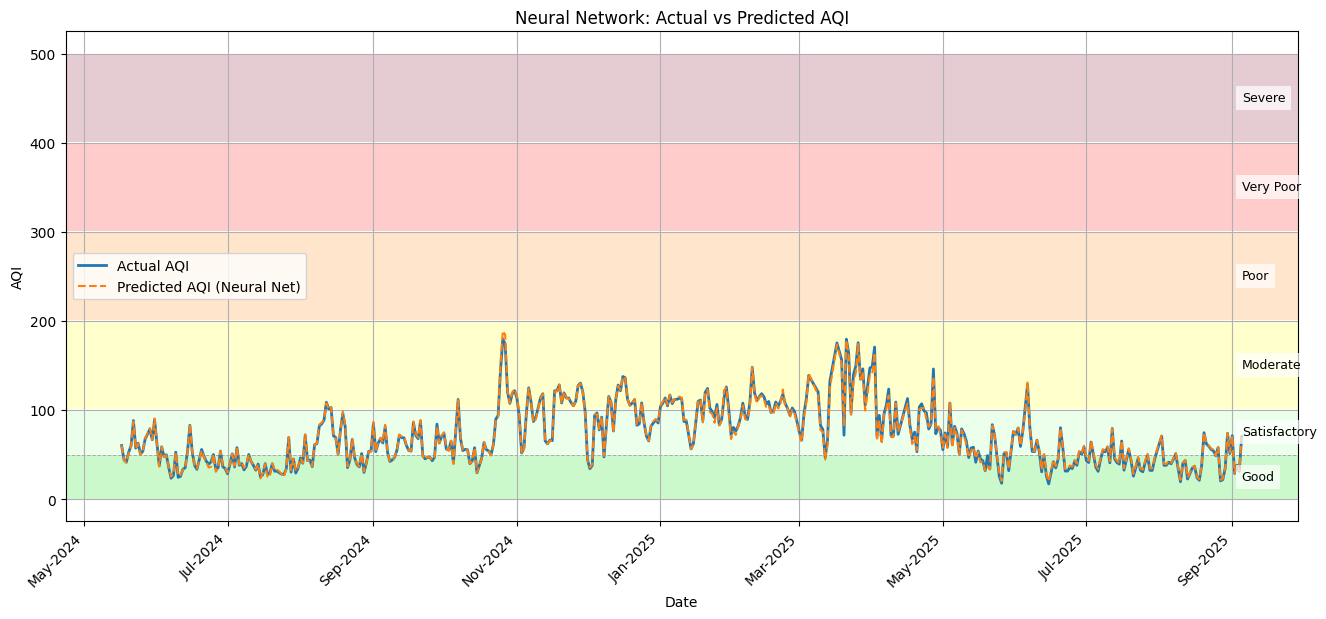

In [11]:
# ─── Imports ───────────────────────────────────────────────────────────────
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

# ─── Reproducibility ───────────────────────────────────────────────────────
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# ─── Load Data ─────────────────────────────────────────────────────────────
df = pd.read_excel("ALL_BN.xlsx")
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
print("✅ Data Loaded")
print(f"Original shape: {df.shape}")

# ─── Required columns (numeric features + target) ──────────────────────────
features = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'Ozone']
target = 'AQI'
required_columns = features + [target]

# ─── Clean: drop rows with missing in required columns ─────────────────────
na_before = df[required_columns].isna().sum().sum()
df_clean = df.dropna(subset=required_columns).copy()
na_after = df_clean[required_columns].isna().sum().sum()
dropped_na_rows = na_before - na_after  # count of dropped NA cells; below we also show row count delta

rows_before = len(df)
rows_after_na = len(df_clean)

# ─── Remove AQI outliers via IQR ───────────────────────────────────────────
Q1, Q3 = df_clean[target].quantile([0.25, 0.75])
IQR = Q3 - Q1
lo, hi = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
outlier_mask = (df_clean[target] < lo) | (df_clean[target] > hi)
outliers_removed = int(outlier_mask.sum())
df_clean = df_clean.loc[~outlier_mask].reset_index(drop=True)

# ─── Report cleaning summary ───────────────────────────────────────────────
print("\n🧹 Cleaning Summary")
print(f"Rows before cleaning: {rows_before}")
print(f"Rows after dropping NA rows: {rows_after_na} (dropped {rows_before - rows_after_na})")
print(f"AQI outliers removed (IQR): {outliers_removed}")
print(f"Final rows after all cleaning: {len(df_clean)}")
print(f"Numeric features used: {features}")
print(f"Target used: {target}")

print("\n📄 Head of final dataset sent to model:")
print(df_clean[required_columns + ["Timestamp"]].head())

print("\n📄 Tail of final dataset sent to model:")
print(df_clean[required_columns + ["Timestamp"]].tail())

# ─── Chronological 80/20 split (no shuffling) ─────────────────────────────
n = len(df_clean)
split_index = int(0.8 * n)

X = df_clean[features].copy()
y = df_clean[target].copy()

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
test_dates = df_clean.iloc[split_index:]["Timestamp"].reset_index(drop=True)

# ─── Scale features ────────────────────────────────────────────────────────
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ─── Model builder for Keras Tuner ─────────────────────────────────────────
def build_model(hp: kt.HyperParameters):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))
    # tunes: number of hidden layers (1..3), units per layer (32..256 step 32), activation (relu|tanh)
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(layers.Dense(
            units=hp.Int(f"units_{i}", min_value=32, max_value=256, step=32),
            activation=hp.Choice("activation", ["relu", "tanh"])
        ))
    model.add(layers.Dense(1))  # regression output

    lr = hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss="mse",
                  metrics=["mae"])
    return model

# ─── Hyperparameter Tuning ─────────────────────────────────────────────────
tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=10,
    overwrite=True,
    directory="tuner_dir",
    project_name="aqi_nn_tuning"
)

# Use callbacks for stability
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=15, restore_best_weights=True
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=7, min_lr=1e-6
)

tuner.search(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=0,
    callbacks=[early_stop, reduce_lr]
)

best_model = tuner.get_best_models(num_models=1)[0]

# ─── Train the best model (once more with callbacks) ───────────────────────
history = best_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=0,
    callbacks=[early_stop, reduce_lr]
)

# ─── Predictions and evaluation ────────────────────────────────────────────
y_pred = best_model.predict(X_test_scaled).flatten()

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n📈 Neural Network Performance")
print(f"MSE  : {mse:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"MAE  : {mae:.3f}")
print(f"R²   : {r2:.4f}")

# ─── Taylor Diagram-style metrics ──────────────────────────────────────────
def print_taylor_metrics(y_true, y_hat, name):
    std_ref = np.std(y_true, ddof=0)
    std_model = np.std(y_hat, ddof=0)
    corr = np.corrcoef(y_true, y_hat)[0, 1]
    centered_rmse = np.sqrt(np.mean(((y_hat - y_hat.mean()) - (y_true - y_true.mean()))**2))
    print(f"\n📊 Taylor Metrics — {name}")
    print(f"Std_Ref       : {std_ref:.4f}")
    print(f"Std_Model     : {std_model:.4f}")
    print(f"Correlation   : {corr:.4f}")
    print(f"Centered RMSE : {centered_rmse:.4f}")

print_taylor_metrics(y_test.values, y_pred, "Neural Network")

# ─── AQI categories (bands) ────────────────────────────────────────────────
aqi_categories = [
    (0,   50,  "Good",         "#00e400"),
    (51,  100, "Satisfactory", "#9cff9c"),
    (101, 200, "Moderate",     "#ffff00"),
    (201, 300, "Poor",         "#ff7e00"),
    (301, 400, "Very Poor",    "#ff0000"),
    (401, 500, "Severe",       "#7e0023"),
]

def add_aqi_bands(ax, x_last):
    for low, high, label, color in aqi_categories:
        ax.axhspan(low, high, facecolor=color, alpha=0.2, zorder=0)
        ax.axhline(y=high, color="gray", linestyle="--", linewidth=0.7, alpha=0.6, zorder=1)
        ax.text(x_last, (low + high)/2, label, va="center", ha="left", fontsize=9, color="black",
                bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

# ─── Plot Actual vs Predicted with AQI bands (Date x-axis) ─────────────────
fig = plt.figure(figsize=(14, 7))
ax = plt.gca()
ax.plot(test_dates, y_test.values, label="Actual AQI", linewidth=2)
ax.plot(test_dates, y_pred, label="Predicted AQI (Neural Net)", linestyle="--")

ax.set_title("Neural Network: Actual vs Predicted AQI")
ax.set_xlabel("Date")
ax.set_ylabel("AQI")
ax.grid(True)
ax.legend()

# Format x-axis as Month-Year
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")

# Add AQI bands and category labels aligned to last date
add_aqi_bands(ax, test_dates.iloc[-1])

# Avoid tight_layout warning by manually padding
plt.subplots_adjust(left=0.08, right=0.96, top=0.90, bottom=0.20)
plt.show()


**lstm**

✅ Data Loaded
Original shape: (2347, 20)

🧹 Cleaning Summary
Rows before cleaning: 2347
Rows after dropping NA rows: 2345 (dropped 2)
AQI outliers removed (IQR): 14
Final rows after all cleaning: 2331

📄 Head of final dataset:
   PM2.5    PM10    NO2    NH3   SO2    CO  Ozone         AQI  Timestamp
0  66.20  121.35  80.22  13.74  8.50  1.38  86.96  153.475789 2019-01-01
1  52.06  100.73  77.26  13.56  8.00  1.11  77.22  122.770000 2019-01-02
2  54.24  109.91  79.76  14.58  9.07  1.35  72.68  106.880000 2019-01-03
3  56.64  113.99  82.45  15.13  8.62  1.20  59.44  109.326667 2019-01-04
4  50.48  101.07  82.87  15.03  8.19  1.20  74.76  114.160000 2019-01-05

📄 Tail of final dataset:
          PM2.5       PM10   NO2   NH3   SO2    CO  Ozone        AQI  \
2326  28.549836  71.200898  4.70  3.85  3.51  0.57  12.77  71.200898   
2327  11.690000  28.850000  4.62  3.80  3.98  0.55  14.05  28.850000   
2328  15.190000  37.890000  5.12  4.11  4.24  0.65  10.23  37.890000   
2329  12.510000  31.2

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


462/462 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

📈 LSTM Performance
MSE  : 442.810
RMSE : 21.043
MAE  : 15.570
R²   : 0.6085

📊 Taylor Metrics — LSTM
Std_Ref       : 33.6324
Std_Model     : 25.3453
Correlation   : 0.7806
Centered RMSE : 21.0429


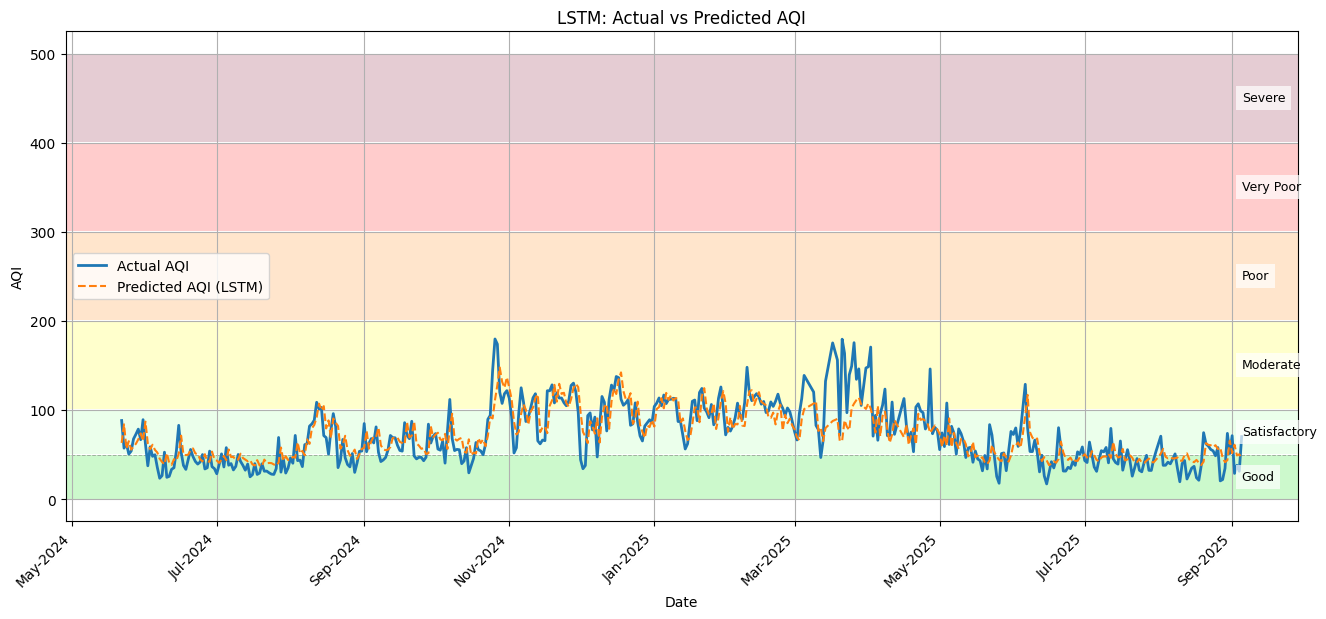

In [14]:
# ─── Imports ───────────────────────────────────────────────────────────────
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

# ─── Reproducibility ───────────────────────────────────────────────────────
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# ─── Load Data ─────────────────────────────────────────────────────────────
df = pd.read_excel("ALL_BN.xlsx")
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
print("✅ Data Loaded")
print(f"Original shape: {df.shape}")

# ─── Required columns ──────────────────────────────────────────────────────
features = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'Ozone']
target = 'AQI'
required_columns = features + [target]

# ─── Clean missing values ──────────────────────────────────────────────────
rows_before = len(df)
na_before = df[required_columns].isna().sum().sum()
df_clean = df.dropna(subset=required_columns).copy()
rows_after_na = len(df_clean)

# ─── Remove outliers (IQR on AQI) ──────────────────────────────────────────
Q1, Q3 = df_clean[target].quantile([0.25, 0.75])
IQR = Q3 - Q1
lo, hi = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
outlier_mask = (df_clean[target] < lo) | (df_clean[target] > hi)
outliers_removed = int(outlier_mask.sum())
df_clean = df_clean.loc[~outlier_mask].reset_index(drop=True)

# ─── Report cleaning summary ───────────────────────────────────────────────
print("\n🧹 Cleaning Summary")
print(f"Rows before cleaning: {rows_before}")
print(f"Rows after dropping NA rows: {rows_after_na} (dropped {rows_before - rows_after_na})")
print(f"AQI outliers removed (IQR): {outliers_removed}")
print(f"Final rows after all cleaning: {len(df_clean)}")

print("\n📄 Head of final dataset:")
print(df_clean[required_columns + ["Timestamp"]].head())
print("\n📄 Tail of final dataset:")
print(df_clean[required_columns + ["Timestamp"]].tail())
print("\n📊 Dataset Summary:")
print(df_clean[required_columns].describe())

# ─── Chronological train/test split ────────────────────────────────────────
n = len(df_clean)
split_index = int(0.8 * n)

X = df_clean[features].copy()
y = df_clean[target].copy()

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
ts_test = df_clean.iloc[split_index:]["Timestamp"].reset_index(drop=True)

# ─── Scaling ───────────────────────────────────────────────────────────────
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ─── LSTM Input Preparation ────────────────────────────────────────────────
lookback = 5
batch_size = 32
train_gen = TimeseriesGenerator(X_train_scaled, y_train.values, length=lookback, batch_size=batch_size)
test_gen = TimeseriesGenerator(X_test_scaled, y_test.values, length=lookback, batch_size=1)

# ─── Model builder for Keras Tuner ─────────────────────────────────────────
def build_lstm(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(lookback, X_train.shape[1])))
    model.add(layers.LSTM(
        units=hp.Int("units", min_value=32, max_value=128, step=32),
        activation=hp.Choice("activation", ["relu", "tanh"])
    ))
    model.add(layers.Dense(1))
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])
        ),
        loss="mse",
        metrics=["mae"]
    )
    return model

tuner = kt.RandomSearch(
    build_lstm,
    objective="val_loss",
    max_trials=5,
    overwrite=True,
    directory="tuner_dir",
    project_name="aqi_lstm_tuning"
)

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)

# ─── Hyperparameter Search ─────────────────────────────────────────────────
tuner.search(train_gen, validation_data=test_gen, epochs=50, verbose=0, callbacks=[early_stop, reduce_lr])
best_model = tuner.get_best_models(1)[0]

# ─── Train best LSTM ───────────────────────────────────────────────────────
history = best_model.fit(train_gen, validation_data=test_gen, epochs=50, verbose=0, callbacks=[early_stop, reduce_lr])

# ─── Predictions & Evaluation ──────────────────────────────────────────────
y_pred = best_model.predict(test_gen).flatten()
y_true = y_test.values[lookback:]   # numpy array
test_dates = ts_test[lookback:].reset_index(drop=True)

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("\n📈 LSTM Performance")
print(f"MSE  : {mse:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"MAE  : {mae:.3f}")
print(f"R²   : {r2:.4f}")

# ─── Taylor Metrics ────────────────────────────────────────────────────────
def print_taylor_metrics(y_true, y_hat, name):
    std_ref = np.std(y_true, ddof=0)
    std_model = np.std(y_hat, ddof=0)
    corr = np.corrcoef(y_true, y_hat)[0, 1]
    centered_rmse = np.sqrt(np.mean(((y_hat - y_hat.mean()) - (y_true - y_true.mean()))**2))
    print(f"\n📊 Taylor Metrics — {name}")
    print(f"Std_Ref       : {std_ref:.4f}")
    print(f"Std_Model     : {std_model:.4f}")
    print(f"Correlation   : {corr:.4f}")
    print(f"Centered RMSE : {centered_rmse:.4f}")

print_taylor_metrics(y_true, y_pred, "LSTM")

# ─── AQI categories ────────────────────────────────────────────────────────
aqi_categories = [
    (0,   50,  "Good",         "#00e400"),
    (51,  100, "Satisfactory", "#9cff9c"),
    (101, 200, "Moderate",     "#ffff00"),
    (201, 300, "Poor",         "#ff7e00"),
    (301, 400, "Very Poor",    "#ff0000"),
    (401, 500, "Severe",       "#7e0023"),
]

def add_aqi_bands(ax, x_last):
    for low, high, label, color in aqi_categories:
        ax.axhspan(low, high, facecolor=color, alpha=0.2, zorder=0)
        ax.axhline(y=high, color="gray", linestyle="--", linewidth=0.7, alpha=0.6, zorder=1)
        ax.text(x_last, (low + high)/2, label, va="center", ha="left", fontsize=9, color="black",
                bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

# ─── Plot Actual vs Predicted ──────────────────────────────────────────────
fig = plt.figure(figsize=(14, 7))
ax = plt.gca()
ax.plot(test_dates, y_true, label="Actual AQI", linewidth=2)
ax.plot(test_dates, y_pred, label="Predicted AQI (LSTM)", linestyle="--")

ax.set_title("LSTM: Actual vs Predicted AQI")
ax.set_xlabel("Date")
ax.set_ylabel("AQI")
ax.grid(True)
ax.legend()

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")

add_aqi_bands(ax, test_dates.iloc[-1])
plt.subplots_adjust(left=0.08, right=0.96, top=0.90, bottom=0.20)
plt.show()


**GRU**

✅ Data Loaded
Original shape: (2347, 20)

🧹 Cleaning Summary
Rows before cleaning: 2347
Rows after dropping NA rows: 2345 (dropped 2)
AQI outliers removed (IQR): 14
Final rows after all cleaning: 2331

📄 Head of final dataset:
   PM2.5    PM10    NO2    NH3   SO2    CO  Ozone         AQI  Timestamp
0  66.20  121.35  80.22  13.74  8.50  1.38  86.96  153.475789 2019-01-01
1  52.06  100.73  77.26  13.56  8.00  1.11  77.22  122.770000 2019-01-02
2  54.24  109.91  79.76  14.58  9.07  1.35  72.68  106.880000 2019-01-03
3  56.64  113.99  82.45  15.13  8.62  1.20  59.44  109.326667 2019-01-04
4  50.48  101.07  82.87  15.03  8.19  1.20  74.76  114.160000 2019-01-05

📄 Tail of final dataset:
          PM2.5       PM10   NO2   NH3   SO2    CO  Ozone        AQI  \
2326  28.549836  71.200898  4.70  3.85  3.51  0.57  12.77  71.200898   
2327  11.690000  28.850000  4.62  3.80  3.98  0.55  14.05  28.850000   
2328  15.190000  37.890000  5.12  4.11  4.24  0.65  10.23  37.890000   
2329  12.510000  31.2

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


462/462 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

📈 GRU Performance
MSE  : 396.668
RMSE : 19.917
MAE  : 14.847
R²   : 0.6493

📊 Taylor Metrics — GRU
Std_Ref       : 33.6324
Std_Model     : 25.6481
Correlation   : 0.8071
Centered RMSE : 19.9113


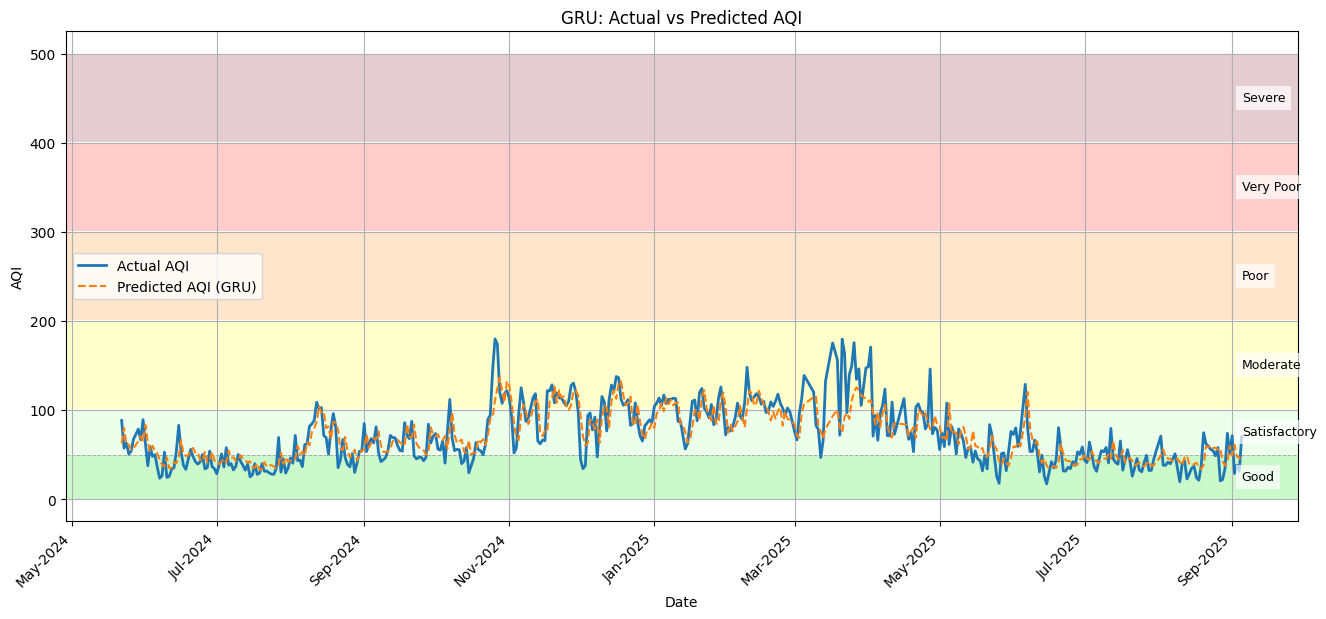

In [15]:
# ─── Imports ───────────────────────────────────────────────────────────────
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

# ─── Reproducibility ───────────────────────────────────────────────────────
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# ─── Load Data ─────────────────────────────────────────────────────────────
df = pd.read_excel("ALL_BN.xlsx")
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
print("✅ Data Loaded")
print(f"Original shape: {df.shape}")

# ─── Required columns ──────────────────────────────────────────────────────
features = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'Ozone']
target = 'AQI'
required_columns = features + [target]

# ─── Clean missing values ──────────────────────────────────────────────────
rows_before = len(df)
na_before = df[required_columns].isna().sum().sum()
df_clean = df.dropna(subset=required_columns).copy()
rows_after_na = len(df_clean)

# ─── Remove outliers (IQR on AQI) ──────────────────────────────────────────
Q1, Q3 = df_clean[target].quantile([0.25, 0.75])
IQR = Q3 - Q1
lo, hi = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
outlier_mask = (df_clean[target] < lo) | (df_clean[target] > hi)
outliers_removed = int(outlier_mask.sum())
df_clean = df_clean.loc[~outlier_mask].reset_index(drop=True)

# ─── Report cleaning summary ───────────────────────────────────────────────
print("\n🧹 Cleaning Summary")
print(f"Rows before cleaning: {rows_before}")
print(f"Rows after dropping NA rows: {rows_after_na} (dropped {rows_before - rows_after_na})")
print(f"AQI outliers removed (IQR): {outliers_removed}")
print(f"Final rows after all cleaning: {len(df_clean)}")

print("\n📄 Head of final dataset:")
print(df_clean[required_columns + ["Timestamp"]].head())
print("\n📄 Tail of final dataset:")
print(df_clean[required_columns + ["Timestamp"]].tail())
print("\n📊 Dataset Summary:")
print(df_clean[required_columns].describe())

# ─── Chronological train/test split ────────────────────────────────────────
n = len(df_clean)
split_index = int(0.8 * n)

X = df_clean[features].copy()
y = df_clean[target].copy()

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
ts_test = df_clean.iloc[split_index:]["Timestamp"].reset_index(drop=True)

# ─── Scaling ───────────────────────────────────────────────────────────────
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ─── GRU Input Preparation ─────────────────────────────────────────────────
lookback = 5
batch_size = 32
train_gen = TimeseriesGenerator(X_train_scaled, y_train.values, length=lookback, batch_size=batch_size)
test_gen = TimeseriesGenerator(X_test_scaled, y_test.values, length=lookback, batch_size=1)

# ─── Model builder for Keras Tuner ─────────────────────────────────────────
def build_gru(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(lookback, X_train.shape[1])))
    model.add(layers.GRU(
        units=hp.Int("units", min_value=32, max_value=128, step=32),
        activation=hp.Choice("activation", ["relu", "tanh"])
    ))
    model.add(layers.Dense(1))
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])
        ),
        loss="mse",
        metrics=["mae"]
    )
    return model

tuner = kt.RandomSearch(
    build_gru,
    objective="val_loss",
    max_trials=5,
    overwrite=True,
    directory="tuner_dir",
    project_name="aqi_gru_tuning"
)

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)

# ─── Hyperparameter Search ─────────────────────────────────────────────────
tuner.search(train_gen, validation_data=test_gen, epochs=50, verbose=0, callbacks=[early_stop, reduce_lr])
best_model = tuner.get_best_models(1)[0]

# ─── Train best GRU ────────────────────────────────────────────────────────
history = best_model.fit(train_gen, validation_data=test_gen, epochs=50, verbose=0, callbacks=[early_stop, reduce_lr])

# ─── Predictions & Evaluation ──────────────────────────────────────────────
y_pred = best_model.predict(test_gen).flatten()
y_true = y_test.values[lookback:]   # numpy array
test_dates = ts_test[lookback:].reset_index(drop=True)

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("\n📈 GRU Performance")
print(f"MSE  : {mse:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"MAE  : {mae:.3f}")
print(f"R²   : {r2:.4f}")

# ─── Taylor Metrics ────────────────────────────────────────────────────────
def print_taylor_metrics(y_true, y_hat, name):
    std_ref = np.std(y_true, ddof=0)
    std_model = np.std(y_hat, ddof=0)
    corr = np.corrcoef(y_true, y_hat)[0, 1]
    centered_rmse = np.sqrt(np.mean(((y_hat - y_hat.mean()) - (y_true - y_true.mean()))**2))
    print(f"\n📊 Taylor Metrics — {name}")
    print(f"Std_Ref       : {std_ref:.4f}")
    print(f"Std_Model     : {std_model:.4f}")
    print(f"Correlation   : {corr:.4f}")
    print(f"Centered RMSE : {centered_rmse:.4f}")

print_taylor_metrics(y_true, y_pred, "GRU")

# ─── AQI categories ────────────────────────────────────────────────────────
aqi_categories = [
    (0,   50,  "Good",         "#00e400"),
    (51,  100, "Satisfactory", "#9cff9c"),
    (101, 200, "Moderate",     "#ffff00"),
    (201, 300, "Poor",         "#ff7e00"),
    (301, 400, "Very Poor",    "#ff0000"),
    (401, 500, "Severe",       "#7e0023"),
]

def add_aqi_bands(ax, x_last):
    for low, high, label, color in aqi_categories:
        ax.axhspan(low, high, facecolor=color, alpha=0.2, zorder=0)
        ax.axhline(y=high, color="gray", linestyle="--", linewidth=0.7, alpha=0.6, zorder=1)
        ax.text(x_last, (low + high)/2, label, va="center", ha="left", fontsize=9, color="black",
                bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

# ─── Plot Actual vs Predicted ──────────────────────────────────────────────
fig = plt.figure(figsize=(14, 7))
ax = plt.gca()
ax.plot(test_dates, y_true, label="Actual AQI", linewidth=2)
ax.plot(test_dates, y_pred, label="Predicted AQI (GRU)", linestyle="--")

ax.set_title("GRU: Actual vs Predicted AQI")
ax.set_xlabel("Date")
ax.set_ylabel("AQI")
ax.grid(True)
ax.legend()

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")

add_aqi_bands(ax, test_dates.iloc[-1])
plt.subplots_adjust(left=0.08, right=0.96, top=0.90, bottom=0.20)
plt.show()


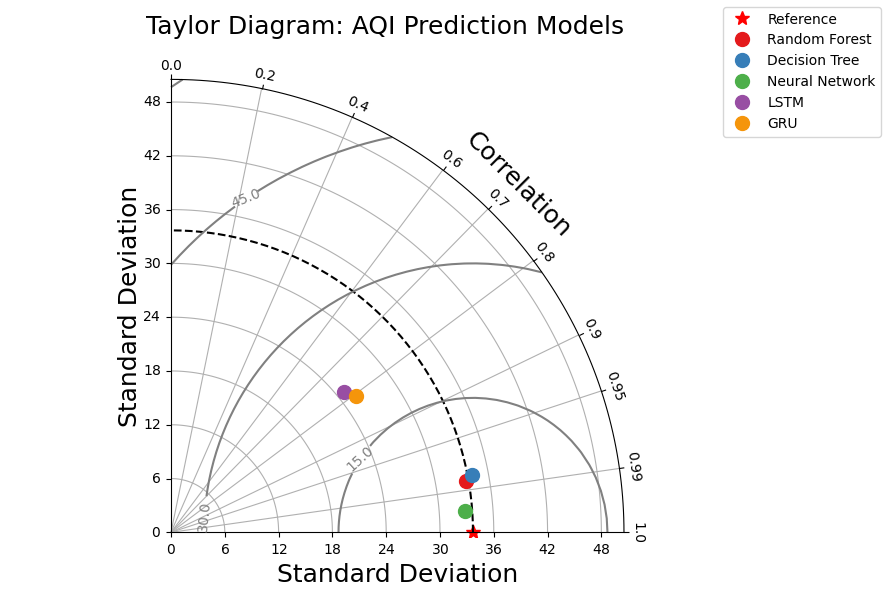

In [31]:
# ─── Imports ─────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from easy_mpl import taylor_plot

# ─── Updated Taylor Metrics Table ─────────────────────────────────────────
taylor_df = pd.DataFrame({
    "Model": [
        "Random Forest",
        "Decision Tree",
        "Neural Network",
        "LSTM",
        "GRU"
    ],
    "Std_Ref": [
        34.4138, 34.4138, 33.5211, 33.6324, 33.6324
    ],
    "Std_Model": [
        33.6119, 34.0119, 32.9495, 25.3453, 25.6481
    ],
    "Correlation": [
        0.9852, 0.9818, 0.9975, 0.7806, 0.8071
    ]
})

# ─── Generate Synthetic Observation Data ────────────────────────────────
np.random.seed(42)
n = 1000
ref_std = taylor_df["Std_Ref"].iloc[0]
observations = np.random.normal(0, ref_std, n)

# ─── Generate Simulated Data for Each Model ──────────────────────────────
def generate_simulation(ref, desired_std, desired_corr):
    noise = np.random.normal(0, 1, len(ref))
    sim = desired_corr * (ref / np.std(ref)) + np.sqrt(1 - desired_corr**2) * noise
    return sim * desired_std

simulations_dict = {
    row["Model"]: generate_simulation(observations, row["Std_Model"], row["Correlation"])
    for _, row in taylor_df.iterrows()
}

# ─── Plot the Taylor Diagram ─────────────────────────────────────────────
fig = taylor_plot(
    observations=observations,
    simulations=simulations_dict,
    marker_style='o',
    marker_size=80,
    legend_loc='upper right',
    figsize=(10, 6),
    title='Taylor Diagram: AQI Prediction Models'
)

plt.show()

In [30]:
!pip install easy_mpl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.5/117.5 kB 9.3 MB/s eta 0:00:00
